# COVID-19 Twitter Research Analysis

This is an analysis done using twitter data categorized into tweets that reference COVID-19, this categorization was done by <CITATION>. We had only scraped the tweets from their tweet id's. 

The data was then subsetted into tweets that are only english, and are tweeted from the United States. As such, any reference to all tweets is a reference to this defined subset of tweets.

The textual data was processed using prebuilt models from flair <CITATION>, where we used the modeling for Part of Speech Tags, Named Entity Recoginition, and the Sentiment of a tweet. These will be used in an attempt to find patterns and get a guage of the general population of twitter users that have tweeted about COVID-19.

## Notes

Please note that this analysis is currently in progress, as such all the information is still under work and needs review.

Some of the functions used are located in seperate python notebooks, this was done to cut down on the amount of code visible in this document.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import os
import sys

sys.path.append(os.path.abspath("C:/Users/Alex/Documents/My Data Files/COVID Research/analysis/mention_2_hashtag.py"))

from analysis.functions.mention_2_hashtag import * 
from analysis.functions.datamanip import *

FIN = 'geo.coord_tweets/flair.joined.tweets.csv'

raw = pd.read_csv(FIN)

# changing date to more readable format
raw['created_at'] = pd.to_datetime(raw['created_at'])

# getting seperated date and time columns
raw['date'] = raw['created_at'].dt.date
raw['time'] = raw['created_at'].dt.time
raw['hour'] = raw['created_at'].dt.hour

# changing na to None
raw = raw.fillna('None')

# only 4 samples that have no sentiment
raw = raw[raw['sentiment'] != 'None']

raw.head()

,created_at,follower_count,friends_count,statefips,countyfips,countyname,ogtext,cleantext,mentions,hashtags,pos,ner,sentiment,date,time,hour
0,2020-02-10 07:03:44+00:00,270.0,539.0,32.0,3.0,Clark,having a mocha and avoiding coronavirus at the...,have mocha avoid coronavirus airport,None,None,"[['having', 'VBG'], ['a', 'DT'], ['mocha', 'NN...",None,POSITIVE,2020-02-10,07:03:44,7
1,2020-02-10 07:04:49+00:00,199.0,216.0,36.0,81.0,Queens,our hearts beat with china,heart beat china,['linsapna'],None,"[['our', 'PRP$'], ['hearts', 'NNS'], ['beat', ...",None,POSITIVE,2020-02-10,07:04:49,7
2,2020-02-10 07:05:30+00:00,235.0,130.0,4.0,13.0,Maricopa,people stop my sister in the street to make fu...,people stop sister street fun wearing mask s a...,None,None,"[['people', 'NNS'], ['stop', 'VBP'], ['my', 'P...",None,POSITIVE,2020-02-10,07:05:30,7
3,2020-02-10 07:10:48+00:00,60008.0,51176.0,5.0,119.0,Pulaski,coronavirus death toll surpasses the number o...,coronavirus death toll surpass number fatal...,None,None,"[['coronavirus', 'NN'], ['death', 'NN'], ['tol...",None,NEGATIVE,2020-02-10,07:10:48,7
4,2020-02-10 07:11:11+00:00,60008.0,51176.0,5.0,119.0,Pulaski,coronavirus cases aboard japanese cruise ship...,coronavirus case aboard japanese cruise shi...,None,None,"[['coronavirus', 'NN'], ['cases', 'NNS'], ['ab...",None,NEGATIVE,2020-02-10,07:11:11,7


Here is the head of the data, as we can see the part of speech includes each word and POS tag from flair. Also, not every tweet has a named entity. The date, time, and hour of the tweet posted are also seperated from the 'created_at' column.

## Info on data

Lets try and get a feel for what all this data includes.

In [3]:
print('Shape of data:', raw.shape)
print('first recorded tweet:', raw['date'].min())
print('last recorded tweet:', raw['date'].max())
print('The Number of tweets for sentiment value')
print(raw['sentiment'].value_counts())

Shape of data: (353563, 16)
first recorded tweet: 2020-01-22
last recorded tweet: 2020-06-12
The Number of tweets for sentiment value
NEGATIVE    224588
POSITIVE    128975
Name: sentiment, dtype: int64


Lets dive in:

* As we can see there are ~308k tweets over the course of about 4 months, all from the US.
* The tweets start on Janurary 22, 2020 and end on June 6, 2020.
* There are roughly 85,000 more negative tweets than positive ones.

# Basic Overview

Here we will start to take a look into what divides the sentiment.

## What is the difference in sentiment for words being tweeted?

Lets take a look at some the sentiment of the words being tweeted.

Text(0.5, 0.01, &#39;Counts of all tweets, seperated by positive and negative sentiments&#39;)

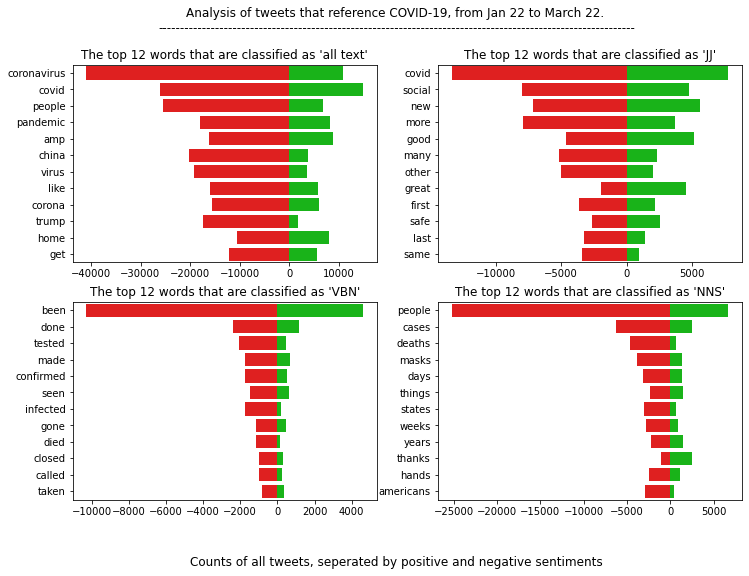

In [4]:
# tags to search for in chart
POStags = ['all text', 'JJ', 'VBN', 'NNS']
Nwords = 12

# figure setup
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), sharex= False)
fig.suptitle('Analysis of tweets that reference COVID-19, from Jan 22 to March 22. \n-------------------------------------------------------------------------------------------------------------')

# search for words by pos tags
for i, tag in enumerate(POStags): 
    if i == 0:
        # raw words
        poslist = text_lister(raw[raw['sentiment'] == 'POSITIVE']['cleantext'])
        neglist = text_lister(raw[raw['sentiment'] == 'NEGATIVE']['cleantext'])
    else:
        # tagged words
        poslist = filter_pos(raw[raw['sentiment'] == 'POSITIVE']['pos'], tag)
        neglist = filter_pos(raw[raw['sentiment'] == 'NEGATIVE']['pos'], tag)
    
    # join lists
    verbdf = count_n_seperate(poslist, neglist, Nwords) 

    # plotting positive counts
    p1 = sns.barplot(data=verbdf, x='poscount', y='word', palette= ['#00cc00'], ax= ax[i//2, i%2])
    # plotting negative counts
    p1 = sns.barplot(data=verbdf, x='negcount', y='word', palette= ['#ff0000'], ax= ax[i//2, i%2]).set_title(f"The top {Nwords} words that are classified as '{tag}'")
    # labels
    ax[i//2, i%2].set_xlabel("")
    ax[i//2, i%2].set_ylabel("")

plt.figtext(0.5, 0.01, "Counts of all tweets, seperated by positive and negative sentiments", ha="center", fontsize=12)
# fig.legend([0,1], labels=["Positive", "Negative"], bbox_to_anchor=(0.825,1.1), loc=1, title="Sentiment")

This shows a strong disparity of the top 12 words for each category. Most of these shown words have a strong disparity between negative and positive Sentinent, where the negative sentiment has a higher proportion for most words. This could very well be due to the fact that the overall sentiment has a much higher proportion of negative tweets. However, an interesting note is that there are a few words where the positive counts outnumber the negative counts.

## How does the sentiment of tweets change over time?

$ A^{(j)} = \textit{ The event that } 
\left\{
    \begin{array}{ll}
        A^{(0)}  & \mbox{if sentiment is } negative  \\
        A^{(1)} & \mbox{if sentiment is } positive
    \end{array}
\right. | \mbox{ } A \subset tweets, \mbox{ } j \in \mathbb{Z}_2 $

$ B_n = \textit{ The event that a tweet occurs on:}\mbox{ }\mbox{ }\mbox{ } day_0, \mbox{ } ..., \mbox{ } day_n 
\mbox{ } | \mbox{ } \forall \textit{ days } \exists  \textit{ n, st. n} \in \mathbb{Z}_{ \textit{ max(days)} } $

<br />

$ P(A^{(j)}|B_n) = 
\left\{
    \begin{array}{ll}
        P(A^{(0)}|day_n) = 100 \bullet ( \frac{ A^{(0)} } { A^{(0)}+A^{(1)} } ) \\
        P(A^{(1)}|day_n) = 100 \bullet ( \frac{ A^{(1)} } { A^{(1)}+A^{(0)} } )
    \end{array}
\right. $

$ \frac{d} {dB} P(A^{(j)}|B_n) = P(A^{(j)}|day_{n-1}) - P(A^{(j)}|day_{n}) \mbox{ }_\blacksquare $

Lets take a look at the tweets by Sentinent over the course of the data. A few things we want to look at are:

* The overal number of positive and negative tweets over time.
    + This can give us an idea of how many tweets are being tweeted.

* The proportion of positive and negative tweets over time.
    + This can give us a general overview of sentiment.
        - If sentiment is close to 50%, then there is little disparity in opinions, whereas if the proportion of sentiment has a greater area between the two, then a we can try and guage the difference of opinions in the twitter users.

* The daily change in proportion of sentiment, over time.
    + If we see big spikes, then this tells us that the sentiment change is more drastic from the past day.
        - This gives a sense of how volatile the sentiment is from day to day.

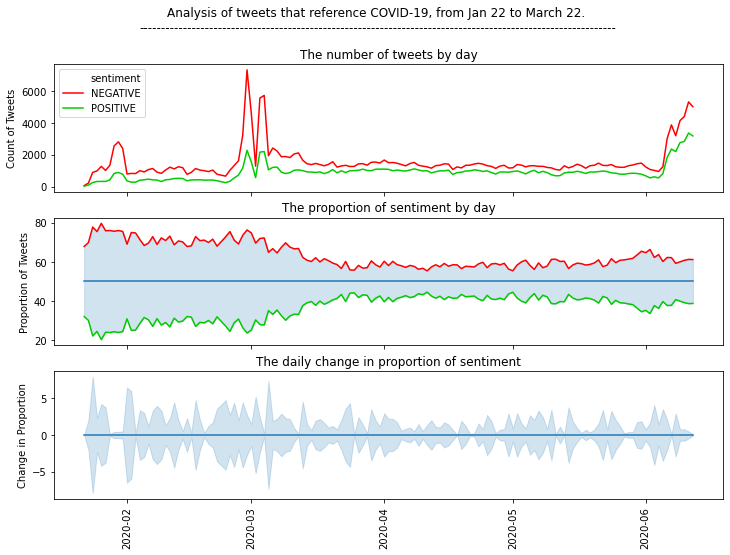

In [5]:
ntweetdf, propdf = ntweet_prop_dfs(raw, 'date', 'sentiment')


# plotting ##########

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 8), sharex= True)
fig.suptitle('Analysis of tweets that reference COVID-19, from Jan 22 to March 22. \n-------------------------------------------------------------------------------------------------------------')

# plot 1
plot = sns.lineplot(data= ntweetdf, x= 'date', y="num_of_tweets", hue= 'sentiment', palette= ['#ff0000', '#00cc00'], ax= ax[0])
plot = plot.set_title("The number of tweets by day")
plot = plt.xticks(rotation=60)
ax[0].set(ylabel='Count of Tweets')

# plot 2
p1 = sns.lineplot(data= propdf, x= 'date', y="proportion", ax= ax[1])
p1 = sns.lineplot(data= propdf, x= 'date', y="proportion", palette= ['#ff0000', '#00cc00'], hue= 'sentiment', ax= ax[1], legend=False).set_title("The proportion of sentiment by day")
ax[1].set(ylabel='Proportion of Tweets')

# plot 3
sns.lineplot(data= propdf, x= 'date', y="difference", ax= ax[2]).set_title("The daily change in proportion of sentiment")
ax[2].set(ylabel='Change in Proportion')

# plot shared x axis
plot = plt.xlabel("")
plot = plt.xticks(rotation=90)

In this figure we can see that in January and March there are big spikes in the total amount of tweets. However one thing to note is that the negative sentiment tweets are consistently above the positive tweets, which means that for every day since January 22nd, 2020, there have been consistently more negative tweets than positive ones.

The next thing to note is that the proportion of sentiment from January to about March 15th has the largest area between the two, this means that there is a bigger disparity of sentiment in twitter users during these dates. After this the proportions tend torwards 50%, meaning there is less of a disparity, and again appears to start flairing back out around the end of May.

For the last graphic, the daily change in proportion shows that the proportion of tweets is more volative from January to about March 15th. Meaning that twitter users sentiment was more likely change during these times, while the rest of the time seems to have comparitavely less volitility.

Overall, we can see that from the end of January to about middle of March shows more amounts of tweets, has a higher disparity in sentiment, and the tweets seem to have a higher probability of their sentiment changing.

## How does sentiment change over the course of a day?

Next lets use the above logic, except look into how the sentiment changes over the course of a single day. This can possibly give insights into if the time a tweet is submitted from a user effects the sentiment of the tweet.

<<<<<<<<<<<<<<<>>>>>>>>>>>>>

This needs to be fixed:

* Timezones are off, as this is currently in universal Timezones
* second graph range of y axis is not [0,100]

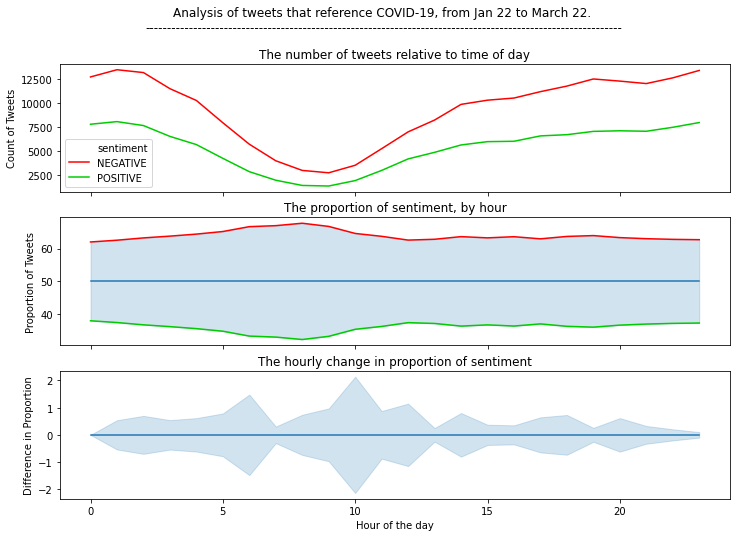

In [6]:
ntweetdf, propdf = ntweet_prop_dfs(raw, 'hour', 'sentiment')

# plotting ##########

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 8), sharex= True)
fig.suptitle('Analysis of tweets that reference COVID-19, from Jan 22 to March 22. \n-------------------------------------------------------------------------------------------------------------')

# plot 1
plot = sns.lineplot(data= ntweetdf, x= 'hour', y="num_of_tweets", hue= 'sentiment', palette= ['#ff0000', '#00cc00'], ax=ax[0])
plot = plot.set_title("The number of tweets relative to time of day")
ax[0].set(ylabel='Count of Tweets')

# plot 2
p1 = sns.lineplot(data= propdf, x= 'hour', y="proportion", ax= ax[1])
p1 = sns.lineplot(data= propdf, x= 'hour', y="proportion", palette= ['#ff0000', '#00cc00'], hue= 'sentiment', ax= ax[1], legend=False).set_title("The proportion of sentiment, by hour")
ax[1].set(ylabel='Proportion of Tweets')

# plot 3
sns.lineplot(data= propdf, x= 'hour', y="difference", ax= ax[2]).set_title("The hourly change in proportion of sentiment")
ax[2].set(ylabel='Difference in Proportion')

# plot shared x axis
plot = plt.xlabel("Hour of the day")

# past here is older and irrelevant code

=================================================================================


In this figure we can see that while the number of tweets vastly varies by hour, the proportion of sentiment stays relatively stable the sum of days. While this might change from day to day, in general we can say that the sentiment of a tweet is not correlated to the time of day it is tweeted.

# Digging deeper into the analysis

Lets dig a bit deeper into the analysis now, looking at subsets of tweets for specific phrases, and the relation of @Mentions, #Hashtags, and the predicted Named Entity Recognitions in tweets.

## What are the differences in sentiment for specific phrases?

Next, lets compare the overall proportion of sentiment to the proportions of sentiment with tweets that contain specific phrases.

<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

write set theory math proof

<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

In [28]:
from analysis.functions.datamanip import *
# adds columns for phrases
phraselist = ['mask', "social distancing", "economy", "work"]
phrasedf = search_phrases(raw, phraselist)
phrasedf['date'] = pd.to_datetime(phrasedf['date'])
rawntweetdf, rawpropdf = ntweet_prop_dfs(raw, 'date', 'sentiment')

dates = pd.period_range(raw['date'].min(), raw['date'].max(), freq='D')

# plotting ##########

fig, ax = plt.subplots(nrows=len(phraselist), ncols=1, figsize=(12, 8), sharex= True, sharey=True)
fig.suptitle('Analysis of tweets that reference COVID-19, from Jan 22 to June 6.\nThe background corrosponds to the total difference of tweet proportions, by day.\n-------------------------------------------------------------------------------------------------------------')

for i, phrase in enumerate(phraselist):
    pcol = ".".join(phrase.split(' '))
    pcol = f'in.{pcol}'

    ntweets = len(phrasedf[phrasedf[pcol] == 1].index)

    ntweetdf, propdf = ntweet_prop_dfs(phrasedf[phrasedf[pcol] == 1], 'date', 'sentiment')

    # base plot
    base = sns.lineplot(data= rawpropdf, x= 'date', y="proportion", ax= ax[i], legend=False)
    ax[i].set(ylabel='Proportion of Tweets')
    
    # trying to give linebreaks for missing dates
    pos = propdf[propdf['sentiment'] == 'POSITIVE']

 #################################
 # trying to not show line when there are no dates  
  
    # # using the resample method
    # pos.set_index(pos.date, inplace=True)
    # pos = pos.resample('D').sum().fillna(0).reset_index()
    # overlay = sns.lineplot(data= pos, x= 'date', y="proportion", palette= ['#00cc00']*sum(pos["sentiment"].isna()), hue=pos['proportion'].isna().cumsum(), ax= ax[i], legend=False)

    # neg = propdf[propdf['sentiment'] == 'POSITIVE']
    # neg = neg.reindex(dates)
    # overlay = sns.lineplot(data=neg, x= 'date', y="proportion", palette= ['#ff0000']*sum(neg["sentiment"].isna()), hue= neg['proportion'].isna().cumsum(), ax= ax[i], legend=False).set_title(f"Tweets that mention '{phrase}', n={ntweets}")

#################################

    overlay = sns.lineplot(data= propdf[propdf['sentiment'] == "POSITIVE"], x= 'date', y="proportion", palette= ['#00cc00'], hue='sentiment', ax= ax[i], legend=False)

    overlay = sns.lineplot(data= propdf[propdf['sentiment'] == "NEGATIVE"], x= 'date', y="proportion", palette= ['#ff0000'], hue='sentiment', ax= ax[i], legend=False).set_title(f"Tweets that mention '{phrase}', n={ntweets}")
    ax[i].set(ylabel='Proportion of Tweets')


# plot shared x axis
plot = plt.xlabel("")
plot = plt.xticks(rotation=90)
fig.legend([0,1,2], labels=["50%", "Positive", "Negative"], bbox_to_anchor=(0.825,1.0), loc=1, title="Sentiment")


UnboundLocalError: local variable &#39;globalcnt&#39; referenced before assignment

Here we can see that the subsets of tweets containing the individual phrases tend to have vastly different proportions in the sentiment, as opposed to the set of all tweets.

Tweets containing 'mask'

* There is a clear disparity in sentiment, with the negative sentiment winning throughout the course of the twitter data. 
* There are a few spots that get within 50% sentiment proportions
    + This would mean that during these times the number of tweets for positive and negative sentiment were roughly the same.

Tweets containing 'social distancing'

* For this subset, there actually were very little amounts of tweets before March 1st.
* Besides initial disparity between sentiments, it starts to normalize torwards 50% sentiment and stays similar to the set of all tweets.
* 

Tweets containing 'economy'

* Here we see that the disparity betweet sentiments stays consitently high, with a negative sentiment taking the lead.
* The tweets have a high volitility in the daily change of proportions, where a few of the days converge to 50%, however quickly bounce back.

Tweets containing 'work'

* Here we see that the tweets sentiment are consistently within the area of the set of overall tweets.
    + This suggests that tweets referencing work tend to have more mixed feelings, which is shown by the swapping of sides from the middle of March to the end of May.

## Are there relations between Mentions, Hashtags, and Named Entities?

Here we will hope to gain insights into any relations between the following:

* '@' Mentions, which reference another twitter user.
* '#' Hashtags, which can mean anything from a movement to a subset of users.
* Named Entity Recognitions, which are modeled from flair using their API package. <REFERNCE>

<<<<<<<<<<<<<>>>>>>>>>>>

insert math once section is done


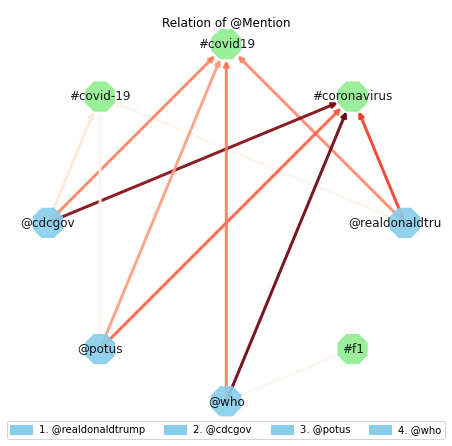

In [6]:
Nmentions = 4
Nhashtags = 3

data = get_mentions_hashtags(raw, Nmentions, Nhashtags)

data = data.replace('covidー19', 'covid-19')

data['mention'] = '@' + data['mention']
data['hashtag'] = '#' + data['hashtag']

nodes = data['mention'].unique()

G=nx.from_pandas_edgelist(data, 'mention', 'hashtag', create_using=nx.DiGraph())

plt.figure(figsize=(6,6))

color_map = []
for node in G:
    if node in nodes:
        color_map.append('skyblue')
    else: 
        color_map.append('lightgreen')

nx.draw_circular(G, with_labels=True, node_size=1000, alpha=0.9, arrows=True, edge_color=data['proportion'], width=3.0, edge_cmap=plt.cm.Reds, node_color=color_map, node_shape="8")
plt.suptitle("Relation of @Mention")

labs = [str(i+1) + '. ' for i in range(Nmentions)] + data['mention'].unique()

leg = plt.legend(labs, loc='lower center', ncol=6, frameon=True, borderaxespad= 0)
#leg.set_title('Ranking of Mentions')
for i in range(Nmentions):
    leg.legendHandles[i].set_color('skyblue')

plt.show()

This graph shows the relation of mentions to hashtags.

From this we can see that almost every mention had a top hashtag of '#coranavirus', which would make sense as these tweets were scraped from <REFERENCE>, which pulled tweets that reference COVID-19 in some way.

In [7]:
data

,mention,hashtag,count,proportion
0,@realdonaldtrump,#coronavirus,789,0.106205
1,@realdonaldtrump,#covid19,573,0.077130
2,@realdonaldtrump,#covid-19,172,0.023153
3,@cdcgov,#coronavirus,232,0.148718
4,@cdcgov,#covid19,124,0.079487
5,@cdcgov,#covid-19,53,0.033974
6,@potus,#coronavirus,122,0.093344
7,@potus,#covid19,89,0.068095
8,@potus,#covid-19,31,0.023718
9,@who,#coronavirus,158,0.154902


The counts are very low, however the data is being redone to include all english tweets here.


# Things to add

These are the updates to come:

* Find two different colors! NO red and green, definitely not red and blue

* Time is in universal timezone, will need to be changed!!

* Location of tweets will be added

* All data will be subset into all english tweets for most of the analysis.

* Only US tweets will be used to look into different aspects by state and county.

* The mentions, hashtags, and NER relations section will be revamped
    + mentions -> hashtags & hashtags -> mentions
    + NER -> hashtags & NER -> mentions & swapped both?
    + mentions, hashtags, and NER tables?

* US map of sentiment
    + difference from 50%, so it scales from negative to positive
    + animated proportion per day timeline?

* Phrase topics are not set in stone
    + better phrase searches?
        - search via part of speech
            + ie, if 'mask' and NOUN
    + group words into categories?
        - ie, work + job + ect.